# Compare and benchmark the calculation of dipole matrix elements with pairinteraction and ARC

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from numerov.angular import calc_angular_matrix_element
from numerov.radial import calc_radial_matrix_element
from numerov.rydberg import RydbergState
from numerov.units import ureg

logging.basicConfig(level=logging.INFO, format="%(levelname)s %(filename)s: %(message)s")
logging.getLogger("numerov").setLevel(logging.WARNING)

In [ ]:
k_radial, k_angular = 1, 1

# A few exemplary test cases, where pairinteraction and ARC do fail in various ways
# dn, dl, dj, dm = (1, 1, 1, 0)
dn, dl, dj, dm = (3, 1, 0, 0)
# dn, dl, dj, dm = (1, 0, 0, 0)
# dn, dl, dj, dm = (2, 0, 0, 0)
# dn, dl, dj, dm = (2, 2, 2, 0)
# dn, dl, dj, dm = (5, 1, 0, 0)
# dn, dl, dj, dm = (5, 2, 1, 0)
# qn_list: (n, l, j, mj)
q = dm

# n_list = list(range(20, 120))
# dl1 = 15
# qn1_list = [(n1, n1 - dl1, n1 - dl1 + 0.5, n1 - dl1 + 0.5) for n1 in n_list]
# qn2_list = [(n + dn, l + dl, j + dj, m + dm) for n, l, j, m in qn1_list]

n_list = list(range(30, 100))
l1 = 25
qn1_list = [(n, l1, l1 + 0.5, l1 + 0.5) for n in n_list]
qn2_list = [(n + dn, l + dl, j + dj, m + dm) for n, l, j, m in qn1_list]

# k_radial, k_angular = 1, 1
# n_list = list(range(7, 80))
# qn1_list = [(n, 0, 0.5, 0.5) for n in n_list]
# qn2_list = [(n + 2, 1, 1.5, 0.5) for n in n_list]
# q = 0

In [3]:
matrixelements_dict = {}

In [4]:
matrixelements = []
for qn1, qn2 in zip(qn1_list, qn2_list):
    print(f"n={qn1[0]}", end="\r")
    state_i = RydbergState("Rb", *qn1)
    state_f = RydbergState("Rb", *qn2)
    radial = calc_radial_matrix_element(state_i, state_f, k_radial)
    angular = calc_angular_matrix_element(state_i, state_f, "p", k_angular, q)
    dipole = radial * angular
    matrixelements.append(dipole)

matrixelements_dict["Numerov"] = np.array(matrixelements)

In [5]:
if int(np.__version__.split(".")[0]) < 2:
    import os

    from pairinteraction import pireal as pi

    os.makedirs("./.pairinteraction_cache/", exist_ok=True)
    cache = pi.MatrixElementCache("./.pairinteraction_cache/")

    cache.setMethod(pi.NUMEROV)
    matrixelements = []
    for qn1, qn2 in zip(qn1_list, qn2_list):
        print(f"n={qn1[0]}", end="\r")
        state_i = pi.StateOne("Rb", int(qn1[0]), int(qn1[1]), qn1[2], qn1[3])
        state_f = pi.StateOne("Rb", int(qn2[0]), int(qn2[1]), qn2[2], qn2[3])

        dipole = cache.getElectricMultipole(state_i, state_f, k_radial, k_angular)
        matrixelements.append(dipole)

    matrixelements = np.array(matrixelements)
    pi_unit_to_au = (ureg.Quantity(1, "cm/V") * ureg.Quantity(1, "GHz").to("J", "spectroscopy")).to("e * a_0").magnitude

    matrixelements_dict["pairinteraction numerov"] = matrixelements * pi_unit_to_au

else:
    print(f"pairinteraction not available with numpy >= 2.0, but numpy {np.__version__} is installed.")

In [6]:
import arc

atom = arc.Rubidium87()

matrixelements = []
for qn1, qn2 in zip(qn1_list, qn2_list):
    print(f"n={qn1[0]}", end="\r")
    v = atom.getDipoleMatrixElement(
        *qn1,
        *qn2,
        q=q,
    )
    matrixelements.append(v)

matrixelements_dict["ARC"] = np.array(matrixelements)

Numerov 16.512633378019494
pairinteraction numerov 16.512436583245325
ARC 16.513223866591996


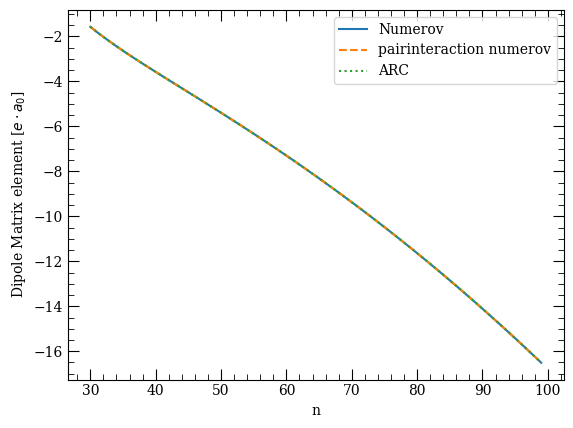

In [7]:
ls_dict = {"pairinteraction numerov": "--", "ARC": ":"}

fig, ax = plt.subplots()

for key, values in matrixelements_dict.items():
    ls = ls_dict.get(key, "-")
    ax.plot(n_list, values, ls=ls, label=key)
    print(key, np.max(np.abs(values)))

ax.set_xlabel("n")
ax.set_ylabel(r"Dipole Matrix element [$e \cdot a_0$]")

ax.legend()
plt.show()